# Dimentionality reduction
* https://courses.analyticsvidhya.com/courses/take/dimensionality-reduction-for-machine-learning/lessons/10881918-high-correlation-filter

Here are some of the benefits of applying dimensionality reduction to a dataset:

* Space required to store the data is reduced as the number of dimensions comes down
* Fewer dimensions lead to less computation/training time
* Some algorithms do not perform well when we have large dimensions. So reducing these dimensions needs to happen for the algorithm to be useful
* It takes care of multicollinearity by removing redundant features. For example, you have two variables – ‘time spent on a treadmill in minutes’ and ‘calories burnt’. These variables are highly correlated as the more time you spend running on a treadmill, the more calories you will burn. Hence, there is no point in storing both as just one of them does what you require
* It helps in visualizing data. As discussed earlier, it is very difficult to visualize data in higher dimensions so reducing our space to 2D or 3D may allow us to plot and observe patterns more clearly

Dimensionality reduction can be done in two different ways:

* By only keeping the most relevant variables from the original dataset (this technique is called feature selection)
* By finding a smaller set of new variables, each being a combination of the input variables, containing basically the same information as the input variables (this technique is called feature extraction). Feature extraction will be divided into 2 parts:
> * Factor/Component-based method
> * Projection Based Methods

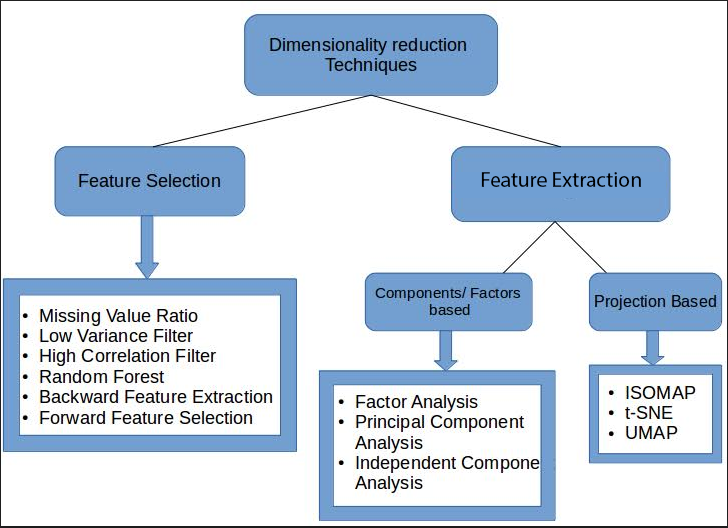

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Feature selection

Removes irrelevant and redundant data
* __Filter Method__: missing values, correlation, variance
* __Wrapper methods__ find the best combination of variables: backwards stepwise selection, forward stepwise selection
https://slideplayer.com/slide/4646748/
* __Embedded methods (regularization)__: LASSO regression, RIDGE regression

### Missing value ratio:
> * 1) Find out the reason for the missing values
>> * Non-response
>> * Error in data collection/ data entry
>> * Error in reading data
> * 2) Impute missing values
>> * Mean/ median/ mode/ train a model

In [55]:
file = './data/missing_value_ratio-200306-192816.csv'
na = pd.read_csv(file)
print(na.shape)
na.head(1)

(12980, 10)


,ID,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,AB101,1.0,0.0,0.0,1.0,9.84,14.395,81.0,NaN,16


In [221]:
def na_ratio_percent(df):
    """returns the percentage of missing values 
    in each column of the data frame"""
    na = round(df.isnull().sum()/df.shape[0]*100,2)
    return na.sort_values(ascending=False)

In [129]:
na_ratio_percent(na)

holiday       48.50
windspeed     41.02
workingday     0.07
season         0.07
humidity       0.04
weather        0.03
count          0.00
atemp          0.00
temp           0.00
ID             0.00
dtype: float64

In [130]:
def threshold_na_cols(df, threshold=40):
    """returns a list of variables 
    having missing values less than a threashhold"""
    return [df.columns[i] for i in range(df.columns.shape[0])
            if na_ratio_percent(df)[i] <= threshold]

In [131]:
# select variables with less than 40% of missing values
variable = threshold_na_cols(var_df)

# slicing the df
not_na = na[variable]
print(not_na.shape)
# two variables were dropped: 'holiday', 'windspeed'
not_na.head(1)

(12980, 6)


,ID,temp,atemp,humidity,windspeed,count
0,AB101,9.84,14.395,81.0,NaN,16


### Low variance
Variance: how far the points are from the mean

* 1) Decide a threshold variance value
* 2) Drop the variables having less variance than the threshold
> * Normalize the variables before calculating variance

In [132]:
# import the normalize function
from sklearn.preprocessing import normalize

In [133]:
file_var = './data/low_variance_filter-200306-194411.csv'
var_df = pd.read_csv(file_var)
print(var_df.shape)
var_df.head(3)

(12980, 6)


,ID,temp,atemp,humidity,windspeed,count
0,AB101,9.84,14.395,81,0.0,16
1,AB102,9.02,13.635,80,0.0,40
2,AB103,9.02,13.635,80,0.0,32


In [134]:
# checking missing values
na_ratio_percent(var_df)

count        0.0
windspeed    0.0
humidity     0.0
atemp        0.0
temp         0.0
ID           0.0
dtype: float64

In [135]:
# checking the type of the variables
var_df.dtypes

ID            object
temp         float64
atemp        float64
humidity       int64
windspeed    float64
count          int64
dtype: object

In [136]:
# dropping the 'ID' variable, as it does not present any useful information
var_df.drop('ID', axis=1, inplace=True)

In [137]:
# normalize the variable
# variables are range dependable
norm = normalize(var_df)
var_scaled = pd.DataFrame(norm)

# storing the variance and name of variables
variance = var_scaled.var()
variance

0    0.005877
1    0.007977
2    0.093491
3    0.008756
4    0.111977
dtype: float64

In [143]:
def threshold_var_cols(df, threshold=0.006):
    """return columns with variance less than the threshold"""
    # normalize data and calculate the variance
    variance = pd.DataFrame(normalize(df)).var()
    return [df.columns[i] for i in range(len(variance))
            if variance[i] >= threshold]

In [145]:
var_cols = threshold_var_cols(var_df)

In [147]:
var_threshold = var_df[var_cols]
var_threshold.head()

,atemp,humidity,windspeed,count
0,14.395,81,0.0,16
1,13.635,80,0.0,40
2,13.635,80,0.0,32
3,14.395,75,0.0,13
4,14.395,75,0.0,1


In [149]:
# highly correlations because the data is not normalized
var_threshold.var()

atemp           73.137484
humidity       398.549141
windspeed       69.322053
count        25843.419864
dtype: float64

### High correlation
* Determines the relationship between two variables
* Ranges between -1 to 1
* Higher magnitude represents stronger relationship

Problem: high correlation leads to multicollinearity

Handle the problem: 
> * 1) Calculate the correlation between all the independent variables
> * 2) Drop the variable, if the correlation crosses a certain threshold (generally 0.5-0.6)
> * 3) Drop the variables with less correlation with the target variable

In [174]:
var_df.corr()

,temp,atemp,humidity,windspeed,count
temp,1.000000,0.991839,-0.048478,-0.008669,0.415938
atemp,0.991839,1.000000,-0.031606,-0.049997,0.412644
humidity,-0.048478,-0.031606,1.000000,-0.296975,-0.322269
windspeed,-0.008669,-0.049997,-0.296975,1.000000,0.105607
count,0.415938,0.412644,-0.322269,0.105607,1.000000


In [207]:
def threshold_corr(df, label_var, threshold=0.5):
    """return a columns with a correlation 
    with less than the threshold"""
    cols = []
    for n, i in enumerate(df.corr()[label_var]):
        if abs(i) < 0.5:
            cols.append(df.corr().columns[n])
    return cols

In [208]:
threshold_corr(var_df, 'count')

['temp', 'atemp', 'humidity', 'windspeed']

### Backward feature elimination
> * 1) Train the model using all the variables
> * 2) Calculate the performance of the model
> * 3) Eliminate a variable, train the model on remaining variables (n-1)
> * 4) Calculate the performance of the model on new data
> * 5) Identify the eliminated variable 


In [220]:
path_bw = './data/backward_feature_elimination-200308-140938.csv'
bw_df = pd.read_csv(path_bw)
print(bw_df.shape)
bw_df.head(1)

(12980, 9)


,ID,season,holiday,workingday,weather,temp,humidity,windspeed,count
0,AB101,1,0,0,1,9.84,81,0.0,16


In [223]:
# checking missing values
na_ratio_percent(bw_df)

count         0.0
windspeed     0.0
humidity      0.0
temp          0.0
weather       0.0
workingday    0.0
holiday       0.0
season        0.0
ID            0.0
dtype: float64

In [248]:
# creating train and test set
X = bw_df.drop(['ID', 'count'], axis=1)
print(X.shape)
y = bw_df['count']
print(y.shape)

(12980, 7)
(12980,)


In [249]:
# ! pip install mlxtend
# http://rasbt.github.io/mlxtend/

In [250]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LinearRegression

In [259]:
# building the model
lreg = LinearRegression()
sfs1 = sfs(
    # select the model
    lreg, 
    # number of features left while training the model
    k_features=4, 
    forward=False,
    verbose=1,
    scoring='neg_mean_squared_error'
          )

# fitting the model
sfs1 = sfs1.fit(X,y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s finished
Features: 6/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s finished
Features: 5/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
Features: 4/4

In [252]:
feat_names = list(sfs1.k_feature_names_)
print(feat_names)

bw_df_2 = bw_df[feat_names]
bw_df_2['count'] = bw_df['count']
print(bw_df.shape)
print(bw_df_2.shape)

['holiday', 'workingday', 'temp', 'humidity']
(12980, 9)
(12980, 5)


/Users/liviaclarete/.pyenv/versions/coca3/lib/python3.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [253]:
bw_df_2.head()

,holiday,workingday,temp,humidity,count
0,0,0,9.84,81,16
1,0,0,9.02,80,40
2,0,0,9.02,80,32
3,0,0,9.84,75,13
4,0,0,9.84,75,1


### Forward feature selection
* https://medium.com/@sagar.rawale3/feature-selection-methods-in-machine-learning-eaeef12019cc

In [254]:
fw_file = './data/forward_feature_selection-200306-234007.csv'
fw_df = pd.read_csv(fw_file)
print(fw_df.shape)
fw_df.head(1)

(12980, 9)


,ID,season,holiday,workingday,weather,temp,humidity,windspeed,count
0,AB101,1,0,0,1,9.84,81,0.0,16


In [257]:
na_ratio_percent(fw_df)

count         0.0
windspeed     0.0
humidity      0.0
temp          0.0
weather       0.0
workingday    0.0
holiday       0.0
season        0.0
ID            0.0
dtype: float64

In [258]:
X = fw_df.drop(['ID', 'count'], axis=1)
print(X.shape)
y = fw_df['count']
print(y.shape)

(12980, 7)
(12980,)


In [260]:
# building the model
lreg = LinearRegression()
sfs1 = sfs(
    # select the model
    lreg, 
    # number of features left while training the model
    k_features=4, 
    forward=True,
    verbose=1,
    scoring='neg_mean_squared_error'
          )

# fitting the model
sfs1 = sfs1.fit(X,y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s finished
Features: 1/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.1s finished
Features: 2/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
Features: 3/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s finished
Features: 4/4

In [261]:
feat_names = list(sfs1.k_feature_names_)
print(feat_names)

bw_df_2 = bw_df[feat_names]
bw_df_2['count'] = bw_df['count']
print(bw_df.shape)
print(bw_df_2.shape)

['holiday', 'workingday', 'temp', 'humidity']
(12980, 9)
(12980, 5)


/Users/liviaclarete/.pyenv/versions/coca3/lib/python3.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Randon Forest

In [275]:
rf_test_path = './data/test_t02dQwI.csv'
rf_test = pd.read_csv(rf_test_path)
print(rf_test.shape)
rf_test.head(1)

(5681, 11)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.75,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1


In [278]:
rf_train_path = './data/train_kOBLwZA.csv'
rf_train = pd.read_csv(rf_train_path)
print(rf_train.shape)
rf_train.head(1)

(8523, 12)


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.3,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.138


In [280]:
rf_train.dropna(inplace=True)

In [281]:
rf_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4650 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              4650 non-null object
Item_Weight                  4650 non-null float64
Item_Fat_Content             4650 non-null object
Item_Visibility              4650 non-null float64
Item_Type                    4650 non-null object
Item_MRP                     4650 non-null float64
Outlet_Identifier            4650 non-null object
Outlet_Establishment_Year    4650 non-null int64
Outlet_Size                  4650 non-null object
Outlet_Location_Type         4650 non-null object
Outlet_Type                  4650 non-null object
Item_Outlet_Sales            4650 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 472.3+ KB


In [283]:
na_ratio_percent(rf_train)

Item_Outlet_Sales            0.0
Outlet_Type                  0.0
Outlet_Location_Type         0.0
Outlet_Size                  0.0
Outlet_Establishment_Year    0.0
Outlet_Identifier            0.0
Item_MRP                     0.0
Item_Type                    0.0
Item_Visibility              0.0
Item_Fat_Content             0.0
Item_Weight                  0.0
Item_Identifier              0.0
dtype: float64

In [286]:
from sklearn.ensemble import RandomForestRegressor
df = rf_train.drop(['Item_Identifier', 'Outlet_Identifier'], axis=1)
model = RandomForestRegressor(random_state=1, max_depth=10)
df = pd.get_dummies(df)
model.fit(df, rf_train['Item_Outlet_Sales'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

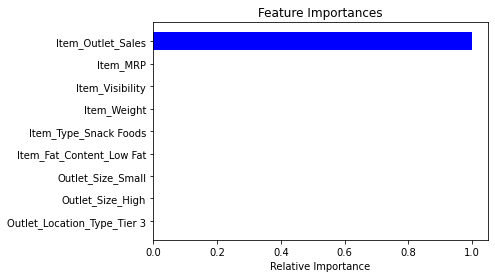

In [290]:
features = df.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-9:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [292]:
from sklearn.feature_selection import SelectFromModel
feature = SelectFromModel(model)
Fit = feature.fit_transform(df, rf_train.Item_Outlet_Sales)

In [293]:
Fit

array([[3735.138 ],
       [ 443.4228],
       [2097.27  ],
       ...,
       [1193.1136],
       [1845.5976],
       [ 765.67  ]])

## Feature extraction
create new features based on the existing one

### Factor based
In the Factor Analysis technique, variables are grouped by their correlations, i.e., all variables in a particular group will have a high correlation among themselves, but a low correlation with variables of other groups (s). Here, each group is known as a factor. These factors are small in number as compared to the original dimensions of the data. However, these factors are difficult to observe.

In [312]:
from glob import glob
import cv2
import tensorflow as tf

In [314]:
mnist = tf.keras.datasets.mnist.load_data(
    path='mnist.npz')

11493376/11490434 [==============================] - 1s 0us/step


In [317]:
images = [cv2.imread(file) for file in glob('./data/train_LbELtWX/train/*.png')]

In [319]:
images = np.array(images)
images.shape

(60000, 28, 28, 3)

In [329]:
image = []
for i in range(0, images.shape[0]):
    img = images[i].flatten()
    image.append(img)
image = np.array(image)

In [334]:
train = pd.read_csv('./data/train_LbELtWX/train.csv')
feat_cols = ['pixel'+ str(i) for i in range(image.shape[1])]
df = pd.DataFrame(image,columns=feat_cols)
df['label'] = train['label']

In [338]:
from sklearn.decomposition import FactorAnalysis
FA = FactorAnalysis(n_components=3).fit_transform(df[feat_cols].values)

In [339]:
FA

array([[ 0.83341433,  0.34840009, -1.15565231],
       [ 0.65992745, -0.30052925,  0.88992389],
       [-0.81881384,  1.48595808,  1.52862151],
       ...,
       [ 1.19921292,  0.27596955, -1.11066968],
       [ 0.05889135, -1.32879088,  1.31893222],
       [ 1.22484109, -1.1014637 ,  1.4596646 ]])

Looks amazing, doesn’t it? We can see all the different factors in the above graph. Here, the x-axis and y-axis represent the values of decomposed factors. As we mentioned earlier, it is hard to observe these factors individually but we have been able to reduce the dimensions of our data successfully.

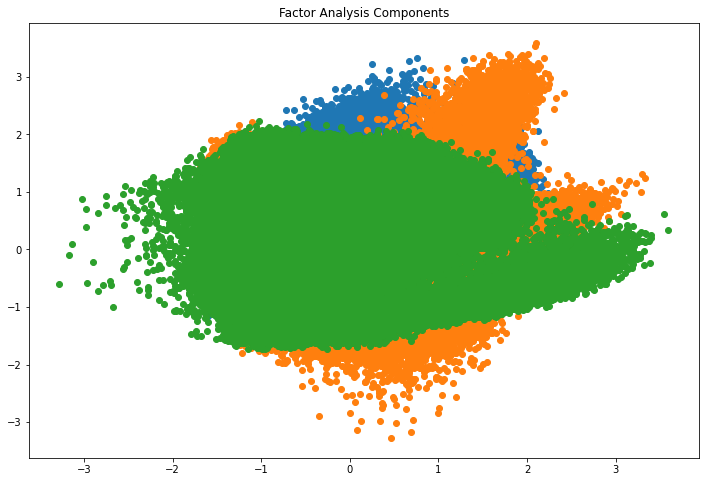

In [340]:
plt.figure(figsize=(12,8))
plt.title('Factor Analysis Components')
plt.scatter(FA[:,0], FA[:,1])
plt.scatter(FA[:,1], FA[:,2])
plt.scatter(FA[:,2],FA[:,0])

### PCA - Principal Component Analysis
A principal component is a linear combination of the original variables

Principal components are extracted in such a way that the first principal component explains maximum variance in the dataset

Second principal component tries to explain the remaining variance in the dataset and is uncorrelated to the first principal component

Third principal component tries to explain the variance which is not explained by the first two principal components and so on

<Figure size 432x288 with 0 Axes>

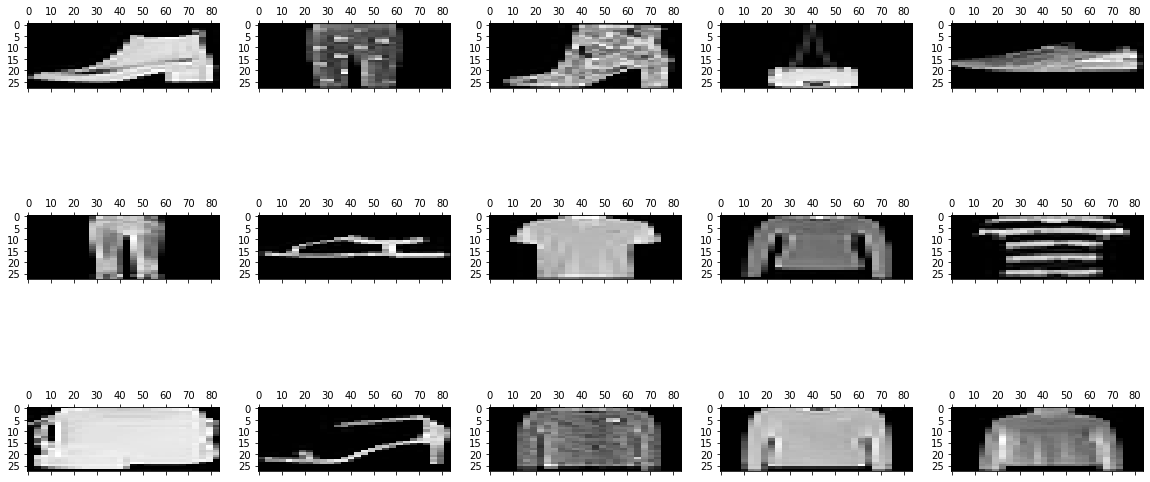

In [349]:
# randomly plot some of the images from our dataset:
rndperm = np.random.permutation(df.shape[0])
plt.gray()
fig = plt.figure(figsize=(20,10))
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1)
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((28,28*3)).astype(float))

In [350]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca_result = pca.fit_transform(df[feat_cols].values)

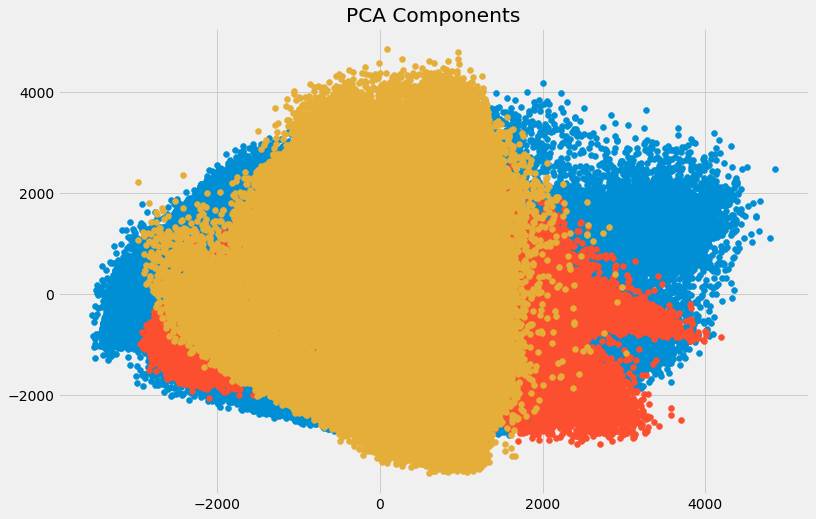

In [366]:
plt.figure(figsize=(12,8))
plt.title('PCA Components')
plt.scatter(pca_result[:,0], pca_result[:,1])
plt.scatter(pca_result[:,1], pca_result[:,2])
plt.scatter(pca_result[:,2],pca_result[:,0])

* the blue line represents component-wise explained variance while the orange line represents the cumulative explained variance. We are able to explain around 60% variance in the dataset using just four components. 

Text(0.5, 1.0, 'Component-wise and Cumulative Explained Variance')

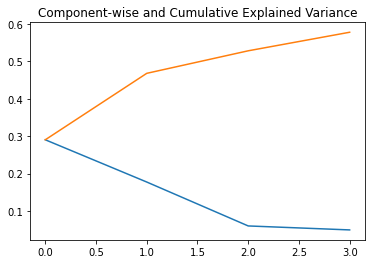

In [353]:
plt.plot(range(4), pca.explained_variance_ratio_)
plt.plot(range(4), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component-wise and Cumulative Explained Variance")

In [356]:
# the 4 components explain 57% of the variance 
sum(pca.explained_variance_ratio_)

0.5776117288288306

* Each additional dimension we add to the PCA technique captures less and less of the variance in the model. The first component is the most important one, followed by the second, then the third, and so on.

Text(0.5, 0.98, '4-Component PCA')

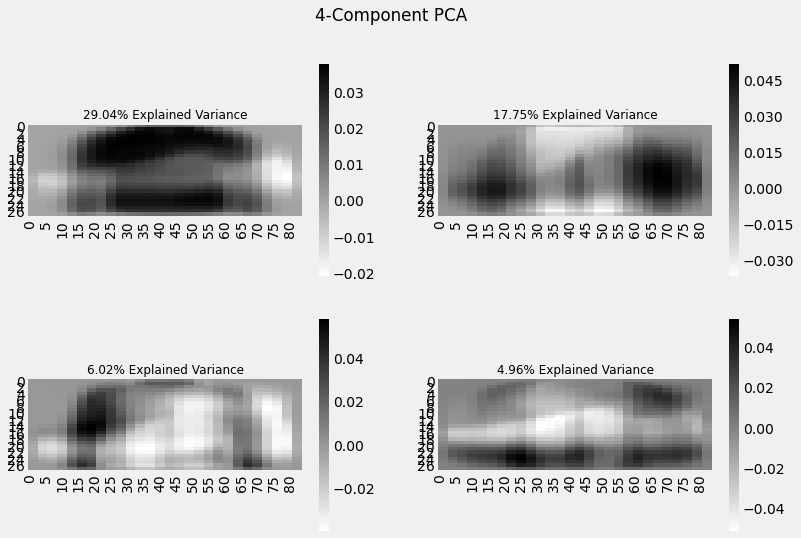

In [358]:
# try to visualize each of these decomposed components:
import seaborn as sns
plt.style.use('fivethirtyeight')
fig, axarr = plt.subplots(2, 2, figsize=(12, 8))
sns.heatmap(pca.components_[0, :].reshape(28, 84), ax=axarr[0][0], cmap='gray_r')
sns.heatmap(pca.components_[1, :].reshape(28, 84), ax=axarr[0][1], cmap='gray_r')
sns.heatmap(pca.components_[2, :].reshape(28, 84), ax=axarr[1][0], cmap='gray_r')
sns.heatmap(pca.components_[3, :].reshape(28, 84), ax=axarr[1][1], cmap='gray_r')
axarr[0][0].set_title(
"{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[0]*100),
fontsize=12
)
axarr[0][1].set_title(
"{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[1]*100),
fontsize=12
)
axarr[1][0].set_title(
"{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[2]*100),
fontsize=12
)
axarr[1][1].set_title(
"{0:.2f}% Explained Variance".format(pca.explained_variance_ratio_[3]*100),
fontsize=12
)
axarr[0][0].set_aspect('equal')
axarr[0][1].set_aspect('equal')
axarr[1][0].set_aspect('equal')
axarr[1][1].set_aspect('equal')

plt.suptitle('4-Component PCA')

### SVD - Singular Value Decomposition (SVD)

SVD decomposes the original variables into three constituent matrices. It is essentially used to remove redundant features from the dataset. It uses the concept of Eigenvalues and Eigenvectors to determine those three matrices. We will not go into the mathematics of it due to the scope of this article, but let’s stick to our plan, i.e. reducing the dimensions in our dataset.

In [359]:
from sklearn.decomposition import TruncatedSVD 
svd = TruncatedSVD(n_components=3, random_state=42).fit_transform(df[feat_cols].values)

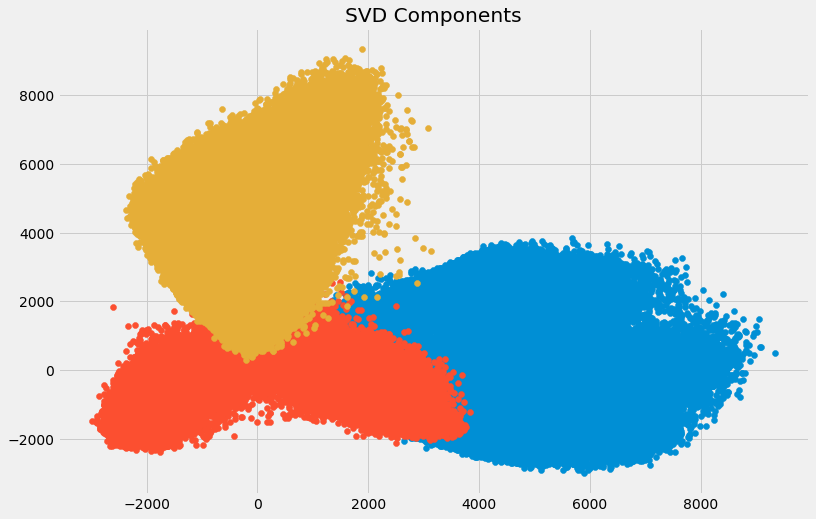

In [360]:
plt.figure(figsize=(12,8))
plt.title('SVD Components')
plt.scatter(svd[:,0], svd[:,1])
plt.scatter(svd[:,1], svd[:,2])
plt.scatter(svd[:,2],svd[:,0])

### Non linear dimentionality reduction
* t-Distributed Stochastic Neighbor Embedding (t-SNE)
* Generalized Low Rank Models (GLRM)